## CNN para previsão de fraturas

**Acerca do Dataset**
- Este conjunto de dados é composto por imagens de raios X fraturadas e não fraturadas de várias articulações. A tarefa é construir um classificador de imagens para detectar fraturas em determinada imagem de raio-X. Este conjunto de dados é composto por diferentes articulações nas extremidades superiores. O isolamento de articulações individuais é recomendado para melhorar o desempenho dos classificadores.
- 8863 instâncias para treino
- 600 instâncias para teste

### Imports

In [12]:
!pip install livelossplot
!pip install monai

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

from livelossplot import PlotLosses

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

from torchvision.datasets import ImageFolder

from monai.networks.nets import resnet

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import Resize
from torchvision.transforms import Grayscale

### 0. Preparar o Setup

In [14]:
PATH_TRAIN = '/kaggle/input/archive (6)/train'
PATH_TEST = '/kaggle/input/archive (6)/val'

BATCH_SIZE = 15

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


### 1. Preparar os dados

In [16]:
transform = Compose(
        [ToTensor(),
         #Grayscale(num_output_channels=1), 
         Resize((224, 224),antialias=True),
         Normalize(mean=(0.1307,), std=(0.3081,))  # Normaliza as imagens
        ])

In [17]:
# Definir a seed

seed = 2024

torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Importar dataset
train_dataset = ImageFolder(PATH_TRAIN, transform=transform)
test_dataset = ImageFolder(PATH_TEST, transform=transform)

validation_split = 0.2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

### 2. Definir o Modelo

In [18]:
model = resnet.resnet18(spatial_dims=2, num_classes=2)

In [19]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [20]:
# função de perda e otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

### 3. Treinar o Modelo

In [21]:
EPOCHS = 10

def train_model(train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {}
        model.train()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float()/len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()


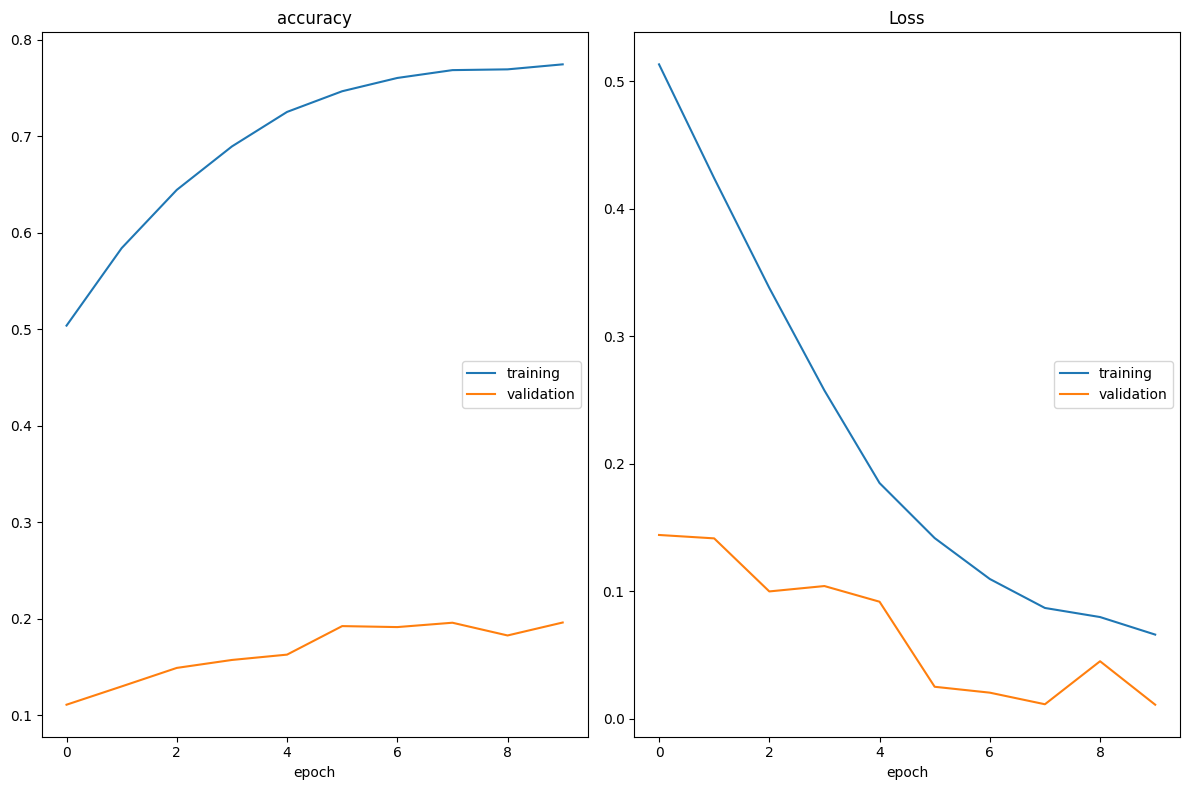

accuracy
	training         	 (min:    0.504, max:    0.775, cur:    0.775)
	validation       	 (min:    0.111, max:    0.196, cur:    0.196)
Loss
	training         	 (min:    0.066, max:    0.513, cur:    0.066)
	validation       	 (min:    0.011, max:    0.144, cur:    0.011)

Training completed in 556.9933035373688 seconds


In [22]:
start_time = time.time()

train_model(train_loader, val_loader, model, criterion, optimizer)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time} seconds")

### 4. Avaliar o modelo

In [23]:
def logits_to_probabilities(logits):
    # logits é uma matriz de formato (n_samples, n_classes)
    # onde n_samples é o número de amostras e n_classes é o número de classes
    exp_logits = np.exp(logits)  # Aplicar exponencial a cada elemento dos logits
    probabilities = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return probabilities

def write_probabilities_to_csv(probabilities, filename):
    np.savetxt(filename, probabilities, delimiter=',', fmt='%.6f')

def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    device = next(model.parameters()).device
    
    model.eval()  # Garantir que o modelo está no modo de avaliação
    
    with torch.no_grad():  # Desativar o cálculo de gradientes durante a avaliação
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            yprev = model(inputs)
            yprev = yprev.detach().cpu().numpy()
            actual = labels.cpu().numpy()
            
            probabilities = logits_to_probabilities(yprev)
            write_probabilities_to_csv(probabilities, '/kaggle/working/probabilities.csv')
            
            yprev = np.argmax(yprev, axis=1)
            actual = actual.reshape((len(actual), 1))
            yprev = yprev.reshape((len(yprev), 1))
            predictions.append(yprev)
            actual_values.append(actual)
            
    predictions = np.vstack(predictions)
    actual_values = np.vstack(actual_values)
    
    return actual_values, predictions

In [24]:
def display_predictions(actual_values, predictions):
    acertou = 0
    falhou = 0
    primeiros = 0
    for r, p in zip(actual_values, predictions):
        if primeiros < 20:
            print(f'real:{r} previsão:{p}')
            primeiros += 1
        if r == p:
            acertou += 1
        else:
            falhou += 1
    
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

In [25]:
def display_confusion_matrix(cm, list_classes):
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True, xticklabels=list_classes, yticklabels=list_classes, annot_kws={"size": 12},
                fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [26]:
actual_values, predictions = evaluate_model(test_loader, model)
display_predictions(actual_values, predictions)

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.18 GiB. GPU 0 has a total capacty of 15.89 GiB of which 7.18 GiB is free. Process 2135 has 8.71 GiB memory in use. Of the allocated memory 7.88 GiB is allocated by PyTorch, and 529.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(classification_report(actual_values, predictions))

In [ ]:
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=['fratured', 'not fractured']
cm = confusion_matrix(actual_values, predictions)
print (cm)

In [ ]:
display_confusion_matrix(cm,list_classes)

### 5. Guardar o Modelo

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/model_densenet.pth')

!ls /kaggle/working